In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [2]:
%config InlineBackend.figure_format = 'svg'

# Data fields
<ol>
    <li> Id - идентификационный номер квартиры </li>
    <li>DistrictId - идентификационный номер района</li>
    <li>Rooms - количество комнат</li>
    <li>Square - площадь</li>
    <li>LifeSquare - жилая площадь</li>
    <li>KitchenSquare - площадь кухни</li>
    <li>Floor - этаж</li>
    <li>HouseFloor - количество этажей в доме</li>
    <li>HouseYear - год постройки дома</li>
    <li>Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности</li>
    <li>Social_1, Social_2, Social_3 - социальные показатели местности</li>
    <li>Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья</li>
    <li>Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров</li>
    <li>Price - цена квартиры</li>
</ol>

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
df = pd.read_csv("train.csv")
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027313         NaN           10.0      4   
1   3013          22    1.0   39.832523   23.169222            8.0      7   
2   8215           1    3.0   78.342216   47.671970           10.0      2   
3   2352           1    1.0   40.409908         NaN            1.0     10   
4  13866          94    2.0   64.285065   38.562515            9.0     16   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         0           NaN            0        0       B  305018.875000  
1         1        1183.0            1        0       B  177734.546875  
2         0         240.0            3        1       B  282078.718750  
3         0           NaN            0        1       B  168106.000000  
4         2           NaN            0        6       B  343995.093750

In [5]:
df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

# 1. EDA

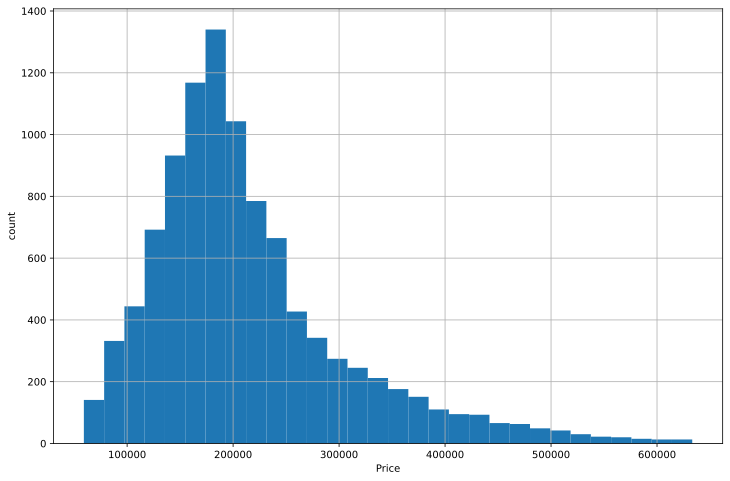

In [6]:
plt.figure(figsize=(12, 8))
df["Price"].hist(bins=30)

plt.ylabel("count")
plt.xlabel("Price")
plt.show()

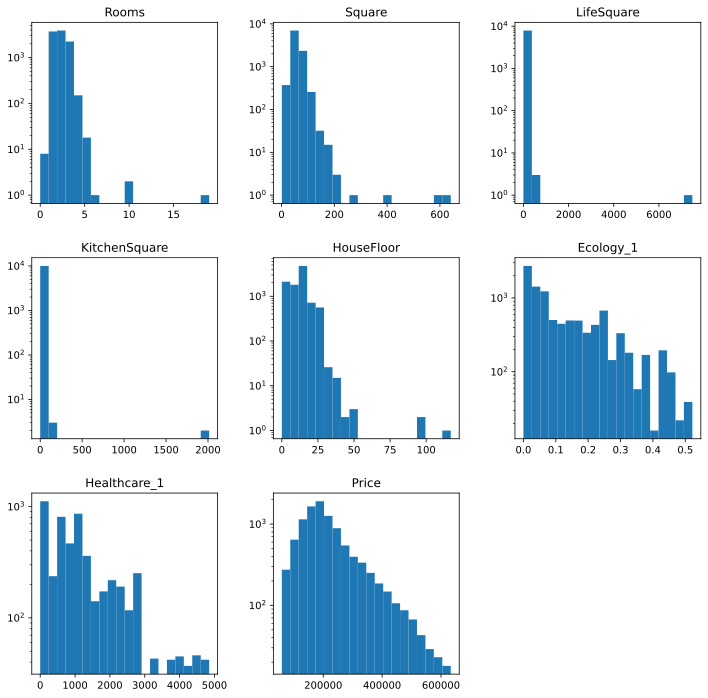

In [9]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.hist(figsize=(12, 12), bins=20, grid=False, log=True);

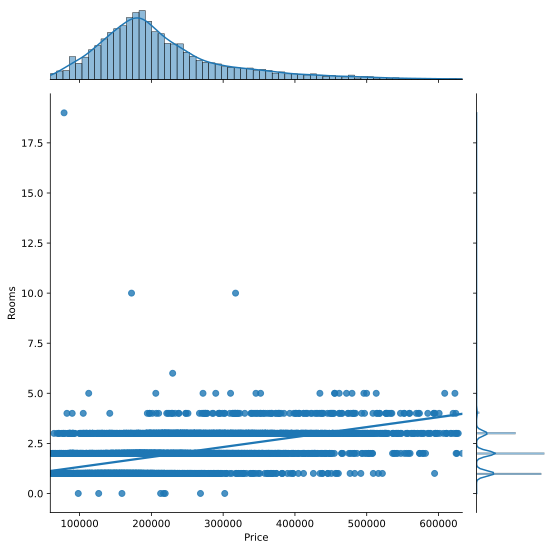

In [10]:
grid = sns.jointplot(df['Price'], df['Rooms'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

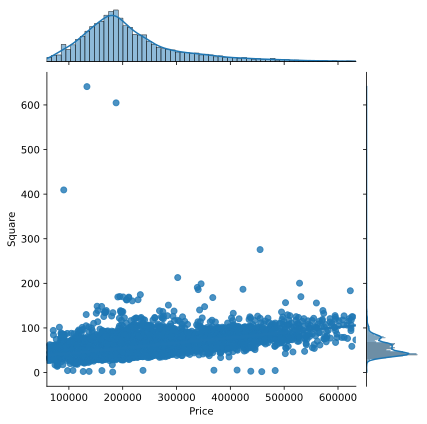

In [13]:
grid = sns.jointplot(df['Price'], df['Square'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

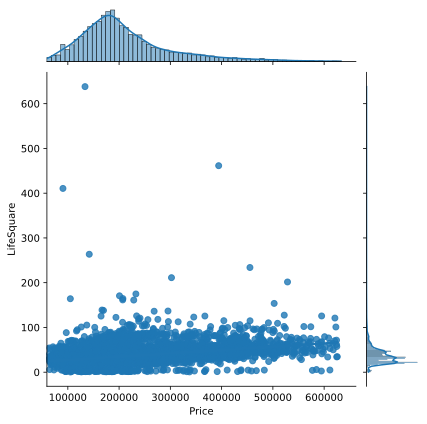

In [15]:
grid = sns.jointplot(df['Price'], df[df['LifeSquare'] < 1000]['LifeSquare'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

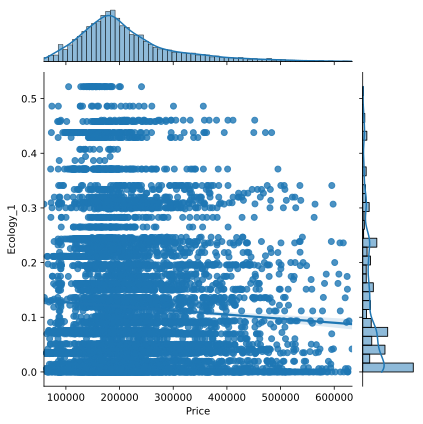

In [23]:
grid = sns.jointplot(df['Price'], df['Ecology_1'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

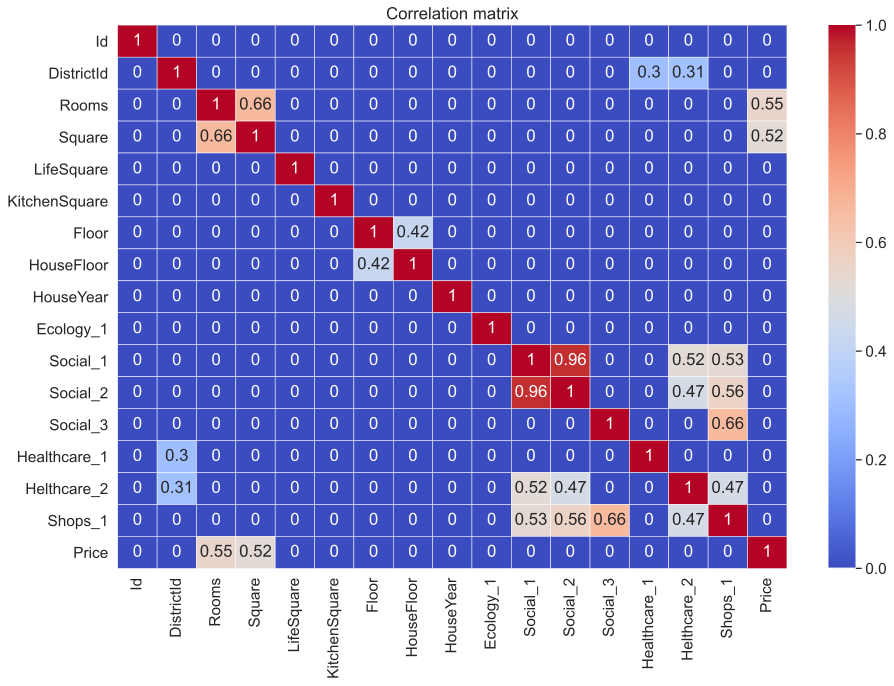

In [24]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

# 2. Preprocessing

In [25]:
df[df['LifeSquare'] > 20]['LifeSquare'].describe()
df[(df['LifeSquare'] < 20) | (df['LifeSquare'] < 1000)]['LifeSquare']

1       23.169222
2       47.671970
4       38.562515
5       47.103832
6       21.772930
          ...    
9995    33.272625
9996    37.038422
9997    16.555363
9998    22.326870
9999    22.301367
Name: LifeSquare, Length: 7886, dtype: float32

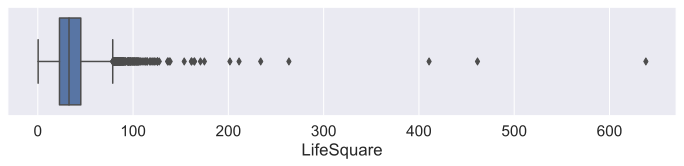

In [26]:
plt.figure(figsize=(12, 2))

sns.boxplot(df[df['LifeSquare'] < 7000]['LifeSquare'])

plt.show()

In [27]:
df.drop(df[(df['LifeSquare'] < 15) & (df['Square'] < 15)].index, inplace=True)
df.drop(df[df['LifeSquare'] > 1000].index, inplace=True)
df.loc[df['LifeSquare'] < 10, "LifeSquare"] = df["LifeSquare"].median()
df['LifeSquare']

0             NaN
1       23.169222
2       47.671970
3             NaN
4       38.562515
          ...    
9995    33.272625
9996    37.038422
9997    16.555363
9998    22.326870
9999    22.301367
Name: LifeSquare, Length: 9990, dtype: float32

In [28]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4791
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [29]:
df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].median())
df['Healthcare_1'] = df['Healthcare_1'].fillna(df['Healthcare_1'].median())
df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [30]:
df = pd.concat([df, pd.get_dummies(df['Ecology_2'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['Ecology_3'])], axis=1)

df.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027313   32.786613           10.0      4   
1   3013          22    1.0   39.832523   23.169222            8.0      7   
2   8215           1    3.0   78.342216   47.671970           10.0      2   
3   2352           1    1.0   40.409908   32.786613            1.0     10   
4  13866          94    2.0   64.285065   38.562515            9.0     16   

   HouseFloor  HouseYear  Ecology_1  ...  Social_3  Healthcare_1  Helthcare_2  \
0        10.0       2014   0.075424  ...         0         900.0            0   
1         8.0       1966   0.118537  ...         1        1183.0            1   
2        17.0       1988   0.025609  ...         0         240.0            3   
3        22.0       1977   0.007122  ...         0         900.0            0   
4        16.0       1972   0.282798  ...         2         900.0            0   

   Shops_1  Shops_2          Price  A  B  A  B  
0        0        B  305018.875000  0  1  0  1  
1        0        B  177734.546875  0  1  0  1  
2        1        B  282078.718750  0  1  0  1  
3        1        B  168106.000000  0  1  0  1  
4        6        B  343995.093750  0  1  0  1  

[5 rows x 22 columns]

In [31]:
df = pd.concat([df, pd.get_dummies(df['Shops_2'])], axis=1)
df.drop(labels=["Ecology_2", "Ecology_3, Shops_2"], axis=1, inplace=True)
df.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027313   32.786613           10.0      4   
1   3013          22    1.0   39.832523   23.169222            8.0      7   
2   8215           1    3.0   78.342216   47.671970           10.0      2   
3   2352           1    1.0   40.409908   32.786613            1.0     10   
4  13866          94    2.0   64.285065   38.562515            9.0     16   

   HouseFloor  HouseYear  Ecology_1  ...  Helthcare_2  Shops_1  Shops_2  \
0        10.0       2014   0.075424  ...            0        0        B   
1         8.0       1966   0.118537  ...            1        0        B   
2        17.0       1988   0.025609  ...            3        1        B   
3        22.0       1977   0.007122  ...            0        1        B   
4        16.0       1972   0.282798  ...            0        6        B   

           Price  A  B  A  B  A  B  
0  305018.875000  0  1  0  1  0  1  
1  177734.546875  0  1  0  1  0  1  
2  282078.718750  0  1  0  1  0  1  
3  168106.000000  0  1  0  1  0  1  
4  343995.093750  0  1  0  1  0  1  

[5 rows x 24 columns]

In [32]:
df.loc[df["KitchenSquare"] > 40, "KitchenSquare"] = df["KitchenSquare"].median()

In [33]:
df.loc[df["HouseFloor"] > 50, "HouseFloor"] = df["HouseFloor"].median()

In [34]:
df[df["Healthcare_1"] > 4000]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
51    12774         157    2.0   62.747509   28.196814            8.0      5   
123     739          84    4.0  102.522270   74.513466            9.0      4   
268   13290         103    3.0   67.992332   46.126312            7.0     16   
362    4026          66    3.0   75.315529   48.968601            7.0      5   
756   15365          86    3.0   58.414036   39.455235            5.0      8   
...     ...         ...    ...         ...         ...            ...    ...   
9517   3128         157    3.0   84.630692   55.849041           11.0      4   
9534   6480          66    3.0   58.867130   41.177135            5.0      2   
9568   9530         190    3.0   58.709335   37.330242            6.0      5   
9637   8506         155    3.0   69.540665   44.117619            7.0      7   
9837   4578          95    2.0   49.396358   29.672499            7.0      6   

      HouseFloor  HouseYear  Ecology_1  ...  Helthcare_2  Shops_1  Shops_2  \
51          10.0       1956   0.000000  ...            5        5        B   
123          5.0       1961   0.149666  ...            4        1        B   
268         16.0       1985   0.000699  ...            0        3        B   
362          5.0       1954   0.161976  ...            3        7        B   
756          9.0       1969   0.161976  ...            3        7        B   
...          ...        ...        ...  ...          ...      ...      ...   
9517         6.0       1930   0.000000  ...            5        5        B   
9534         9.0       1974   0.161976  ...            3        7        B   
9568         9.0       1964   0.000000  ...            5        5        B   
9637        12.0       1972   0.042307  ...            3        6        B   
9837         8.0       1963   0.000699  ...            0        3        B   

             Price  A  B  A  B  A  B  
51    555661.93750  0  1  0  1  0  1  
123   415574.12500  0  1  0  1  0  1  
268   347550.78125  0  1  0  1  0  1  
362   199227.68750  0  1  1  0  0  1  
756   278126.81250  0  1  1  0  0  1  
...            ... .. .. .. .. .. ..  
9517  480227.28125  0  1  0  1  0  1  
9534  255216.62500  0  1  1  0  0  1  
9568  507552.25000  0  1  0  1  0  1  
9637  442267.00000  0  1  0  1  0  1  
9837  334440.53125  0  1  0  1  0  1  

[170 rows x 24 columns]

In [35]:
df.drop(labels=['Id'], axis=1, inplace=True)
df.head()

DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0          27    3.0  115.027313   32.786613           10.0      4   
1          22    1.0   39.832523   23.169222            8.0      7   
2           1    3.0   78.342216   47.671970           10.0      2   
3           1    1.0   40.409908   32.786613            1.0     10   
4          94    2.0   64.285065   38.562515            9.0     16   

   HouseFloor  HouseYear  Ecology_1  Social_1  ...  Helthcare_2  Shops_1  \
0        10.0       2014   0.075424        11  ...            0        0   
1         8.0       1966   0.118537        30  ...            1        0   
2        17.0       1988   0.025609        33  ...            3        1   
3        22.0       1977   0.007122         1  ...            0        1   
4        16.0       1972   0.282798        33  ...            0        6   

   Shops_2          Price  A  B  A  B  A  B  
0        B  305018.875000  0  1  0  1  0  1  
1        B  177734.546875  0  1  0  1  0  1  
2        B  282078.718750  0  1  0  1  0  1  
3        B  168106.000000  0  1  0  1  0  1  
4        B  343995.093750  0  1  0  1  0  1  

[5 rows x 23 columns]

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     9999 non-null   int16   
 1   Rooms          9999 non-null   float32 
 2   Square         9999 non-null   float32 
 3   LifeSquare     9999 non-null   float32 
 4   KitchenSquare  9999 non-null   float32 
 5   Floor          9999 non-null   int8    
 6   HouseFloor     9999 non-null   float32 
 7   HouseYear      9999 non-null   int32   
 8   Ecology_1      9999 non-null   float32 
 9   Ecology_2      9999 non-null   category
 10  Ecology_3      9999 non-null   category
 11  Social_1       9999 non-null   int8    
 12  Social_2       9999 non-null   int16   
 13  Social_3       9999 non-null   int16   
 14  Healthcare_1   9999 non-null   float32 
 15  Helthcare_2    9999 non-null   int8    
 16  Shops_1        9999 non-null   int8    
 17  Shops_2        9999 non-null   ca

In [72]:
class DataPipeline:
    
    """Подготовка исходных данных"""
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df[['LifeSquare', "Healthcare_1"]].median()
        
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        df[['LifeSquare', 'Healthcare_1']] = df[['LifeSquare', 'Healthcare_1']].fillna(self.medians)
        
        
        # 2. Выбросы (outliers)
        df.loc[df["KitchenSquare"] > 40, "KitchenSquare"] = df["KitchenSquare"].median()
        df.loc[df["HouseFloor"] > 50, "HouseFloor"] = df["HouseFloor"].median()
        df.loc[df['LifeSquare'] < 15, "LifeSquare"] = df["LifeSquare"].median()
        df.loc[df['Square'] < 15, 'Square'] = df['Square'].median()
        df.loc[df['Rooms'] < 1, 'Rooms'] = df['Rooms'].median()
        
        #df.drop(df[(df['LifeSquare'] < 15) & (df['Square'] < 15)].index, inplace=True)
        df.drop(df[df['LifeSquare'] > 1000].index, inplace=True)
        
        Id_col = df['Id']
        df.drop(labels=['Id'], axis=1, inplace=True)
        
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'])], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'])], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'])], axis=1)
        df.drop(labels=["Ecology_2", "Ecology_3", "Shops_2"], axis=1, inplace=True)
        
        # 3. Новые фичи (features)
        df['mean_room_square'] = df['LifeSquare'] / df['Rooms']
        
        # 4. Понижение размерности
        pca = PCA(n_components=1, random_state=42)
        df['Social'] = pca.fit_transform(df.loc[:, ['Social_1', 'Social_2']])
        df.drop(labels=['Social_1', 'Social_2'], axis=1, inplace=True)
        
        # 5. Train test split
        y = df.pop('Price')
        X = df
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42) 
        
        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        
        return X_train, X_test, y_train, y_test, Id_col

In [73]:
df = pd.read_csv("train.csv")
df = reduce_mem_usage(df)
data = DataPipeline()
data.fit(df)
X_train, X_test, y_train, y_test, Id = data.transform(df)
X_train

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


array([[-0.07272727, -1.        , -0.59593111, ...,  0.        ,
         0.33062035, -0.28270958],
       [-0.43636364, -1.        , -0.88495323, ...,  0.        ,
         0.90352619,  0.22037023],
       [-0.18181818,  0.        ,  0.02214658, ...,  0.        ,
        -0.21730702,  1.48063939],
       ...,
       [-0.43636364, -1.        , -0.53481637, ...,  0.        ,
         1.0433939 ,  0.22037023],
       [-0.52727273, -1.        , -0.37142752, ...,  0.        ,
         1.96733106, -0.65707225],
       [ 0.49090909,  0.        ,  0.62795012, ..., -1.        ,
         0.13209915, -0.82217666]])

In [66]:
X_train['Rooms'].median()

2.0

In [65]:
X_train[X_train['Rooms'] < 1]

DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
9869          27    0.0    2.377248   32.781261            0.0      1   
2194          88    0.0   38.697117   19.345131            9.0      9   
6401          27    0.0   87.762619   85.125473            0.0      5   
7644          27    0.0  212.932358  211.231125            0.0      2   
9767          27    0.0  138.427689  136.215500            0.0      4   

      HouseFloor  HouseYear  Ecology_1  Social_3  ...  Helthcare_2  Shops_1  \
9869         0.0       1977   0.017647         0  ...            0        0   
2194        16.0       1982   0.127376         3  ...            3        9   
6401        15.0       1977   0.211401         0  ...            0        1   
7644         3.0       2008   0.211401         0  ...            0        1   
9767         3.0       2016   0.075424         0  ...            0        0   

      A  B  A  B  A  B  mean_room_square       Social  
9869  0  1  0  1  0  1               inf -4883.697948  
2194  0  1  0  1  0  1               inf  3076.403915  
6401  0  1  0  1  0  1               inf -3460.681116  
7644  0  1  0  1  0  1               inf -3460.681116  
9767  0  1  0  1  0  1               inf -2255.683293  

[5 rows x 21 columns]

In [57]:
X_train[X_train.isin([np.nan, np.inf, -np.inf]).any(1)]

DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
9869          27    0.0    2.377248   32.781261            0.0      1   
2194          88    0.0   38.697117   19.345131            9.0      9   
6401          27    0.0   87.762619   85.125473            0.0      5   
7644          27    0.0  212.932358  211.231125            0.0      2   
9767          27    0.0  138.427689  136.215500            0.0      4   

      HouseFloor  HouseYear  Ecology_1  Social_3  ...  Helthcare_2  Shops_1  \
9869         0.0       1977   0.017647         0  ...            0        0   
2194        16.0       1982   0.127376         3  ...            3        9   
6401        15.0       1977   0.211401         0  ...            0        1   
7644         3.0       2008   0.211401         0  ...            0        1   
9767         3.0       2016   0.075424         0  ...            0        0   

      A  B  A  B  A  B  mean_room_square       Social  
9869  0  1  0  1  0  1               inf -4883.697948  
2194  0  1  0  1  0  1               inf  3076.403915  
6401  0  1  0  1  0  1               inf -3460.681116  
7644  0  1  0  1  0  1               inf -3460.681116  
9767  0  1  0  1  0  1               inf -2255.683293  

[5 rows x 21 columns]

In [23]:
y = df.pop('Price')
X = df


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = RobustScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [49]:
result(X_train, X_test, y_train, y_test, GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10, max_depth=5))

MAE   ==   28000.23580927142
MSE   ==   2233485866.442452
 r2_test   ==  0.752
 r2_train   ==  0.84


In [80]:
def result(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)
    mse1 = mse(y_test, pred_test)
    #mae = mean_absolute_error(y_test, pred_test)
    r2_sc = r2(y_test, pred_test)
    r2_train = r2(y_train, pred_train)
    print(f'MSE   ==   {mse1}\n r2_test   ==  {round(r2_sc, 3)}\n r2_train   ==  {round(r2_train, 3)}')


In [27]:
result(X_train, X_test, y_train, y_test, LinearRegression())

MAE   ==   45989.954892692534
MSE   ==   4605198533.543279
 r2_test   ==  0.482
 r2_train   ==  0.502


In [28]:
result(X_train, X_test, y_train, y_test, RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42, 
                                 n_estimators=100  # кол-во деревьев
                                 ))

MAE   ==   33002.851411381394
MSE   ==   2867230883.0032115
 r2_test   ==  0.678
 r2_train   ==  0.722


In [29]:
grid = GridSearchCV(GradientBoostingRegressor(), {'n_estimators':[100, 200, 300], 
            'max_depth':[7, 20],
            'min_samples_leaf':[10, 20, 30]}, cv=KFold(n_splits=5, random_state=21, shuffle=True), n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7, 20], 'min_samples_leaf': [10, 20, 30],
                         'n_estimators': [100, 200, 300]})

In [30]:
grid.best_params_

{'max_depth': 7, 'min_samples_leaf': 10, 'n_estimators': 100}

In [31]:
result(X_train, X_test, y_train, y_test, RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=10, random_state=42))

MAE   ==   30654.550222559214
MSE   ==   2611789092.7553315
 r2_test   ==  0.706
 r2_train   ==  0.809


In [32]:
model = GradientBoostingRegressor(n_estimators=300, criterion='mse')
model.fit(X_train, y_train)

array([4.56487938e-03, 6.81994169e-02, 3.17112837e-02, 4.45518053e-01,
       1.47330878e-02, 1.91411813e-02, 1.19794552e-02, 1.91701316e-02,
       3.18275279e-02, 4.20908815e-02, 1.27348330e-01, 5.60196588e-02,
       8.40339323e-02, 2.51731546e-02, 4.85288463e-03, 1.25909468e-02,
       0.00000000e+00, 3.09728542e-04, 1.28193678e-04, 5.51122250e-04,
       0.00000000e+00, 5.61493166e-05])

In [33]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       model.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances

feature_name  importance
0              Id    0.004565
1      DistrictId    0.068199
2           Rooms    0.031711
3          Square    0.445518
4      LifeSquare    0.014733
5   KitchenSquare    0.019141
6           Floor    0.011979
7      HouseFloor    0.019170
8       HouseYear    0.031828
9       Ecology_1    0.042091
10       Social_1    0.127348
11       Social_2    0.056020
12       Social_3    0.084034
13   Healthcare_1    0.025173
14    Helthcare_2    0.004853
15        Shops_1    0.012591
16              A    0.000000
17              B    0.000310
18              A    0.000128
19              B    0.000551
20              A    0.000000
21              B    0.000056

In [34]:
model

GradientBoostingRegressor(criterion='mse', n_estimators=300)

In [35]:
grid = GridSearchCV(GradientBoostingRegressor(), {'n_estimators':[100, 200, 300], 
            'max_depth':[7, 20],
            'min_samples_leaf':[10, 20, 30]}, cv=KFold(n_splits=5, random_state=21, shuffle=True), n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

KeyboardInterrupt: 

In [38]:
result(X_train, X_test, y_train, y_test, GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10, max_depth=7))

MAE   ==   28118.249974282662
MSE   ==   2322227877.4885874
 r2_test   ==  0.742
 r2_train   ==  0.902


In [ ]:
test_df = pd.read_csv('test.csv')
test_df.head()

In [ ]:
dat = DataPipeline()
dat.fit(test_df)
test_df = dat.transform(test_df)
Id = test_df['Id']
test_df.drop(labels=['Id'], axis=1, inplace=True)

In [ ]:
scaler = RobustScaler() 
st_test = scaler.fit_transform(test_df)

In [ ]:
result_model = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10, max_depth=7)
result_model.fit(X_train, y_train)
test_df['Price'] = result_model.predict(st_test)
test_df

In [ ]:
test_df["Id"] = Id
res_df = test_df[['Id', 'Price']]
res_df

In [ ]:
res_df.to_csv('result1.csv', index=False)

In [ ]:
sample = pd.read_csv('sample_submission.csv')
sample

In [ ]:
a = pd.read_csv('result1.csv')
a

In [37]:
result(X_train, X_test, y_train, y_test, GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10, max_depth=7))

MAE   ==   28119.576966673165
MSE   ==   2322867273.9396815
 r2_test   ==  0.742
 r2_train   ==  0.902


In [82]:
grid = GridSearchCV(GradientBoostingRegressor(), {'n_estimators':[100, 200, 300], 
            'max_depth':[3, 5, 7, 10],
            'min_samples_leaf':[10, 20, 30]}, cv=KFold(n_splits=5, random_state=21, shuffle=True), n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [10, 20, 30],
                         'n_estimators': [100, 200, 300]})

In [83]:
grid.best_params_

{'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}

In [84]:
result(X_train, X_test, y_train, y_test, GradientBoostingRegressor(n_estimators=200, min_samples_leaf=10, max_depth=5))

MSE   ==   2264685726.514361
 r2_test   ==  0.748
 r2_train   ==  0.879
